In [1]:
import numpy as np
from PIL import Image
import onnxruntime
import torch

from modules import MRCNNModule

import matplotlib.pyplot as plt
%matplotlib inline

/home/laurent_fainsin/unet/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(onnxruntime.get_device())
print(onnxruntime.get_available_providers())


GPU
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [3]:
net = MRCNNModule(2)


In [4]:
model_path = "/tmp/model.ckpt"
net.load_state_dict(torch.load(model_path)["state_dict"])


<All keys matched successfully>

In [5]:
net.to_onnx(
    "/tmp/test.onnx",
    export_params=True,
    opset_version=11,
    input_names=["input"],
    output_names=["boxes", "labels", "scores", "masks"],
    dynamic_axes={
        "input": {
            0: "batch",
            2: "height",
            3: "width",
        },
        "masks": {
            1: "height",
            2: "width",
        },
    },
)


/home/laurent_fainsin/unet/.venv/lib/python3.8/site-packages/torch/nn/functional.py:3996: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/home/laurent_fainsin/unet/.venv/lib/python3.8/site-packages/torchvision/models/detection/anchor_utils.py:121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  torch.empty((), dtype=torch.int64, device=device).fill_(image_size[0] // g[0]),
/home/laurent_fainsin/unet/.venv/lib/p

In [9]:
image_path = "/media/disk1/lfainsin/TEST/2022_CHAUVET/1/5B0A3375.jpg"

# load test image
image_OG = Image.open(image_path).convert("RGB")
image = np.float32(image_OG)
image = np.moveaxis(image, -1, 0)  # HWC to CHW

# normalize
mean_vec = np.array([0.485, 0.456, 0.406])
stddev_vec = np.array([0.229, 0.224, 0.225])
for i in range(image.shape[0]):
    image[i, :, :] = (image[i, :, :]/255 - mean_vec[i]) / stddev_vec[i]

# add batch dimension
image = image[np.newaxis, :]
# print(image.shape)

ort_session = onnxruntime.InferenceSession("/tmp/test.onnx", providers=["CUDAExecutionProvider"])
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: image}
ort_outs = ort_session.run(None, ort_inputs)

import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(ort_outs)


2022-09-05 13:24:22.445862589 [W:onnxruntime:, graph.cc:3494 CleanUnusedInitializersAndNodeArgs] Removing initializer '3856'. It is not used by any node and should be removed from the model.
2022-09-05 13:24:22.510858095 [W:onnxruntime:, graph.cc:3494 CleanUnusedInitializersAndNodeArgs] Removing initializer '3754'. It is not used by any node and should be removed from the model.
2022-09-05 13:24:22.510872410 [W:onnxruntime:, graph.cc:3494 CleanUnusedInitializersAndNodeArgs] Removing initializer '3756'. It is not used by any node and should be removed from the model.


[ array([[3317.8325 , 4152.044  , 3858.9578 , 4659.242  ],
       [   0.     , 5463.277  ,   48.85818, 5464.     ],
       [4767.4043 , 5463.317  , 4871.8774 , 5464.     ],
       [6976.576  , 5463.0464 , 7085.1553 , 5464.     ],
       [7003.0557 , 5463.3174 , 7111.681  , 5464.     ],
       [6948.4927 , 5463.688  , 7056.8633 , 5464.     ],
       [5938.523  , 5463.0415 , 6045.5146 , 5464.     ]], dtype=float32),
  array([1, 1, 1, 1, 1, 1, 1], dtype=int64),
  array([0.9999889 , 0.24681446, 0.24681446, 0.24681446, 0.24681446,
       0.24681446, 0.24681446], dtype=float32),
  array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.

: 

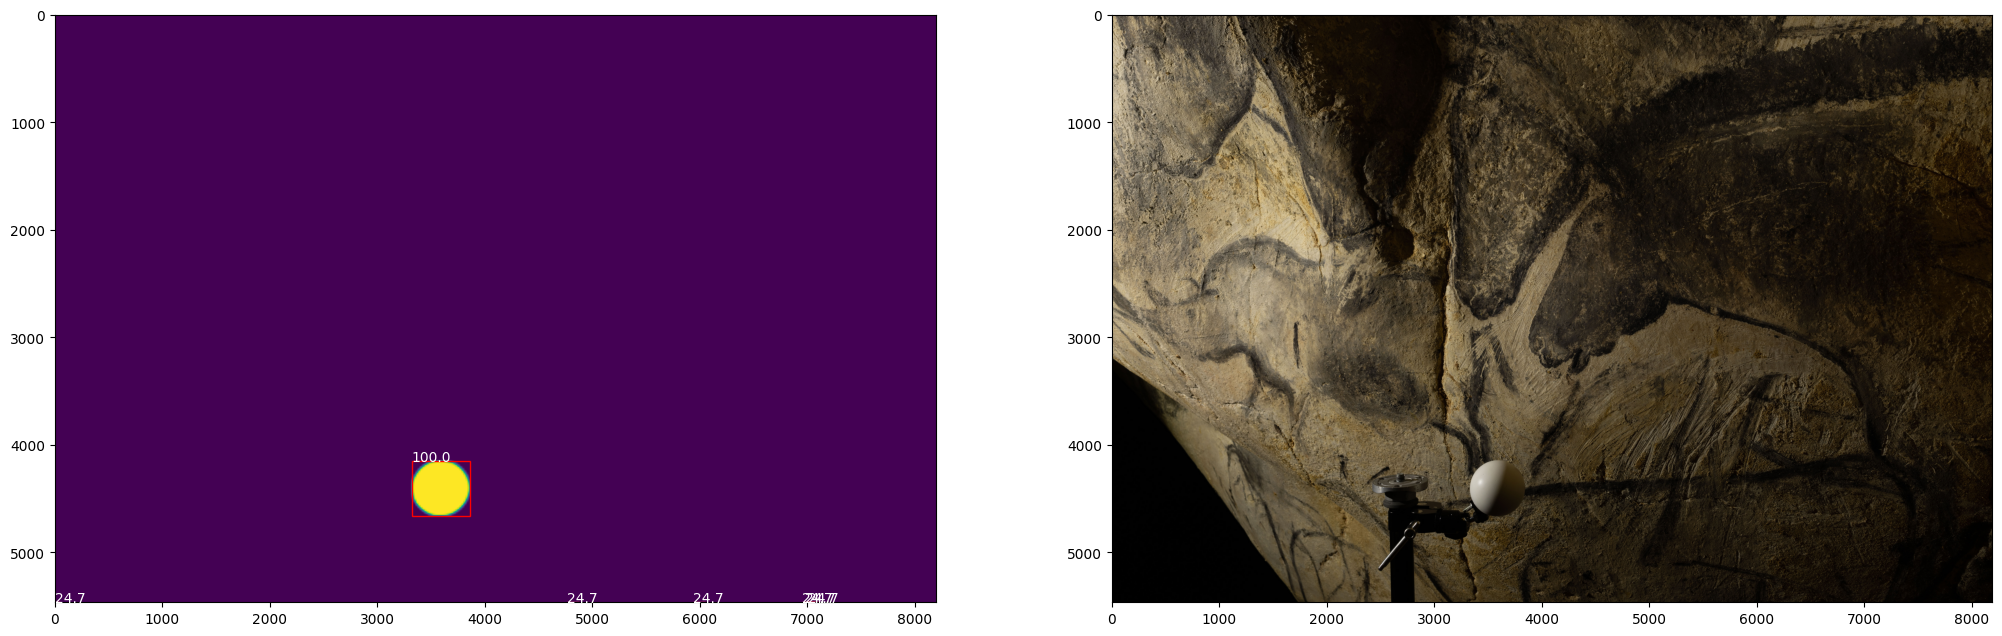

In [7]:
import matplotlib.patches as patches

n = len(ort_outs[3])
mask = torch.zeros(ort_outs[3][0][0].shape)
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

for i in range(n):
    mask += ort_outs[3][i][0]
    boxe = ort_outs[0][i]
    rect = patches.Rectangle(
        (boxe[0], boxe[1]), boxe[2] - boxe[0], boxe[3] - boxe[1], linewidth=1, edgecolor="r", facecolor="none"
    )
    ax[0].annotate(f"{ort_outs[2][i]*100:.01f}", (boxe[0], boxe[1]), color="white")
    ax[0].add_patch(rect)

    mask[mask > 1] = 1

plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(image_OG)
